# Isoformant

`isoformant` is an interactive toolkit for transcript isoform analysis.

## Description

* Processes Oxford Nanopore Technologies (ONT) long transcript sequencing data (i.e. direct RNA and cDNA).
* Isoform analysis is restricted to user-defined region-of-interest (ROI), typically a gene.
* Long reads are clustered based on k-mer density to generate isoform consensus sequences.
* Differential isoform usage hypothesis test based on read distribution among clusters.
* Toolkit to be deployed using `Jupyter` notebook (https://jupyter.readthedocs.io/en/latest/content-quickstart.html).

## Getting Started

### Required inputs

* Sorted alignment .BAM (recommendation: minimap2 -ax splice)
* Reference genome .fasta

### Optional inputs

* UCSC-style isoform annotations .bed (https://genome.ucsc.edu/FAQ/FAQformat.html#format1)

### Installation

* Clone the repo

```{bash}
git clone git@ssh.code.roche.com:LED13/isoformant.git
```

* Create `isoformant` conda environment

```{bash}
conda env create -f ./recipe/environment.yml

source activate isoformant
```

* Make `isoformant` visible to `Jupyter` as kernel

```{bash}
python -m ipykernel install --user --name isoformant
```

### Usage

Details at Read the Docs (https://isoformant.readthedocs.io/en/latest/isoformant.html)

#### Preprocessing: Import isoformant module and assign input variables

* In `Jupyter`, set kernel to `isoformant`

In [1]:
%%capture cap --no-stderr
# capture minimap2 path from conda env
!source activate isoformant && which minimap2

In [2]:
# set module path relative to test directory
import sys,os
sys.path.append(os.path.abspath('./isoformant/'))

# import isoformant
from isoformant import *

# input variables
ncore=1 # CPUs 
minimap2_path = cap.stdout.strip() # minimap2 executable path
ref_fa = './example/SIRV_isoforms_multi-fasta_170612a.fasta' # reference genome 
gene_track = './example/SIRV_isoforms_multi-fasta-annotation_C_170612a_corrected_norm.bed' # Optional, isoform annotations
dest_dir = './example/outputs' # output directory 


#### Module 1: Process region-of-interest (ROI) alignments

In [3]:
# ingest list of BAM files
bams_list = [
    './example/SIRV1_cDNA_sorted.bam',
    './example/SIRV1_RNA_sorted.bam',
]

# assign region-of-interest (ROI)
chrom, start, end = ('SIRV1', 1, 12643)

# process BAM
combined_csv, combined_bam = preprocess_reads(bams_list, 
                                              chrom, # ROI
                                              start, # ROI
                                              end, # ROI
                                              dest_dir, 
                                              max_reads=1000, # limits reads to 'max_reads' per BAM
                                              ncore=ncore, # CPUs
                                              qual_cutoff=15, # min. mean base quality
                                              len_cutoff=500) # min. read length

380it [00:00, 11353.64it/s]
306it [00:00, 15311.33it/s]

>Module: Process BAM files
>>Task: Filter BAM file
	BAM = ./example/SIRV1_cDNA_sorted.bam
	# of records in ROI: 379
	# passing: 353
>>Task: Filter BAM file
	BAM = ./example/SIRV1_RNA_sorted.bam
	# of records in ROI: 305
	# passing: 183


#### Module 2: Long-read k-merization and cluster reads in k-mer space 

29it [00:00, 282.68it/s]

>Module: Read k-merization
>>Task: k-merize CSV reads
	k = 7


366it [00:01, 308.72it/s]


>>Task: Convert k-mer pandas dataframe to anndata object
>>Task: PCA
	# of PCs = 100


/gstore/home/led13/.conda/envs/isoformant/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sample_id' as categorical


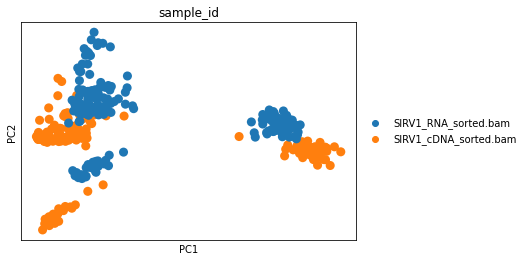

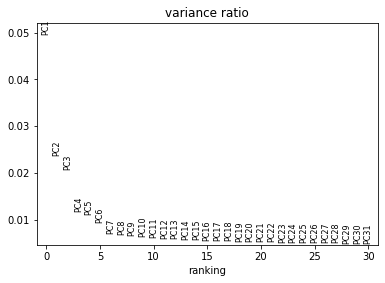

In [4]:
# k-merize sequences and create adata object
adata = kmerize(combined_csv, 
                ksize = 7 # k-mer size
               )

# pca pipeline: dimensionality reduction
pca_pipeline(adata, groupby_list=['sample_id'], n_comps=100, plot=True)

# use Scanpy's variance ratio function to determine appropiate number of PCs for analysis
sc.pl.pca_variance_ratio(adata)

>>Task: UMAP
	# of PCs = 20
	# of neighbors = 10
	Minimum distance = 0.5
	Resolution = 1


/gstore/home/led13/.conda/envs/isoformant/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'leiden' as categorical


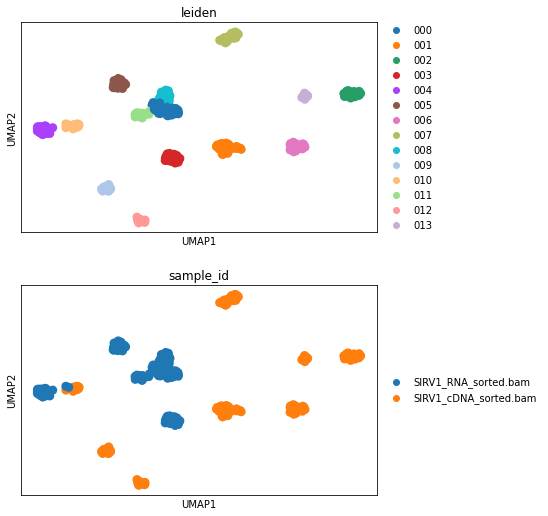

>>Task: Create visualization BAM files
	Maximum number of records per BAM = 10


In [5]:
# umap pipeline: clustering
umap_pipeline(adata, groupby_list=['leiden', 'sample_id'], 
              n_pcs = 20, # number of PCs
              n_neighbors = 10, 
              min_dist = 0.5, 
              resolution = 1, # clustering resolution
              plot = True
             )

# Create BAMs for visualization
label_target = 'leiden'
bam_dict, seq_dict = create_viz_bams(adata, combined_bam, dest_dir + '/viz', cluster_label=label_target, bam_n=10, ncore=ncore)

In [6]:
# # save figure to ./figures/umap{suffix}.pdf using Scanpy's umap function
# suffix = 'your_suffix'
# sc.pl.umap(adata, color=['sample_id','leiden'], ncols=1, save = suffix)

#### Module 3: Consensus (CNS) calling using clustered reads
Relative read abundance in parentheses

 14%|█▍        | 2/14 [00:00<00:03,  3.18it/s]

>Module: Consensus calling
>>Task: POA step


100%|██████████| 14/14 [00:01<00:00,  8.39it/s]


	Number of reads per consensus call = 10
>>Task: Align sequences


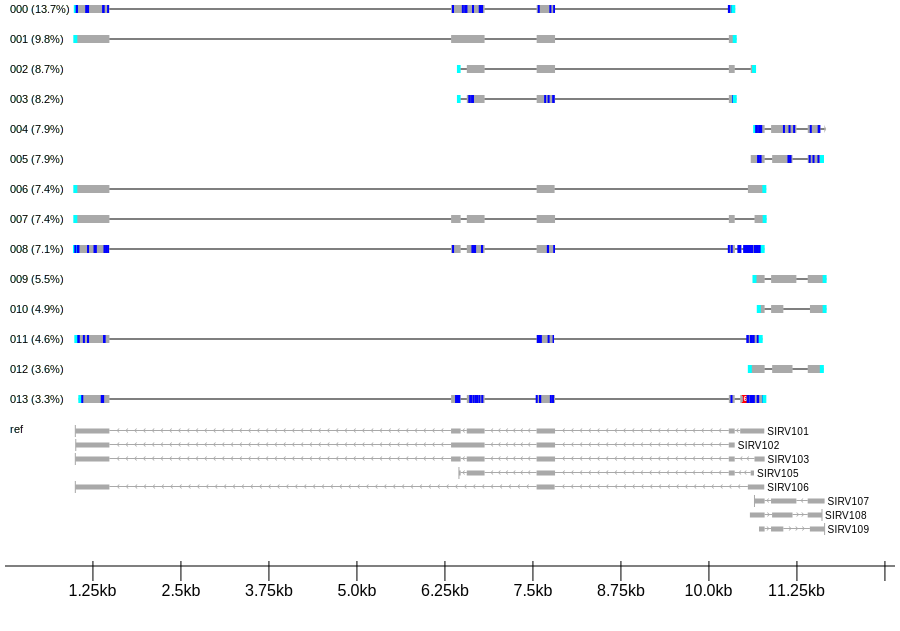

In [25]:
# Consensus calling: POA consensus and mapping with minimap2
sorted_cnsbam, cns_dict = cns(minimap2_path,
                                    seq_dict, 
                                    dest_dir + '/cns', 
                                    ref_fa,
                                    cluster_label = label_target, 
                                    ncore = ncore,
                                    sirv=True
                                   )
# include read abundances
abund_d = adata.obs[label_target].value_counts(normalize = True).to_dict()
keys = cns_dict.keys()
cns_dict_tmp = {}
for key in cns_dict.keys():
    abund_val = round(abund_d.get(key)*100,1)
    cns_dict_tmp[f'{key} ({abund_val}%)'] = cns_dict.get(key)
cns_dict = cns_dict_tmp 

# Visualize set of CNS
track_dict={**cns_dict, **{'ref':gene_track}}
track_dict=collections.OrderedDict(sorted(track_dict.items()))
plot_tracks(track_dict, chrom, int(start), int(end), ref_fa, save=None) #save plot by replacing None with destination path

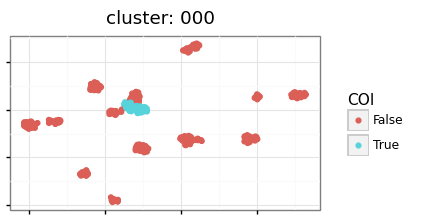

/gstore/home/led13/.conda/envs/isoformant/lib/python3.8/site-packages/genomeview/quickconsensus.py:74: RuntimeWarning: invalid value encountered in true_divide


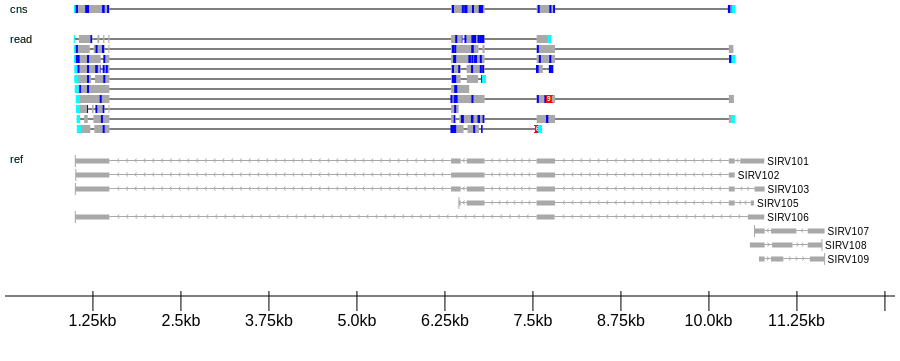

In [14]:
# Visualize single cluster
COI = '000'
plot_highlight_COI(adata, COI, 'leiden')
track_dict={'cns':cns_dict.get([x for x in cns_dict.keys() if x.startswith(COI)][0]), 
            'read':bam_dict.get(COI), 
            'ref':gene_track}
plot_tracks(track_dict, chrom, int(start), int(end), ref_fa, save=None) #save plot by replacing None with destination path

#### Module 4: Differential isoform usage hypothesis testing

In [ ]:
# Chi-squared goodness-of-fit test
results_df = balanced_chisq_test(adata)
display(results_df)

# Plot cluster occupancy by condition label
occupancy_df = plot_cluster_occupancy(adata, fig_size=(8,6))
display(occupancy_df)

## Authors

* Faye T. Orcales (orcalesf@gene.com)
* Daniel D. Le (le.daniel@gene.com)

## Version History

* 0.0.1
    * Initial Release

## License

This project is licensed under the MIT License - see the `LICENSE` file for details

## Acknowledgments

* Analytical strategy and infrastructure borrowed from Scanpy (https://github.com/theislab/scanpy)